49.0
36.0
[0.68766501 0.27549819 0.63184082 0.49474844 0.7        0.7
 0.62762936 0.2        0.55316964 0.58959057 0.68617279 0.31381805
 0.28862258 0.58655168 0.7        0.7        0.2        0.2
 0.7        0.7        0.7        0.40259738 0.2        0.28496745
 0.6053232  0.2        0.2        0.7        0.7        0.7
 0.28236834 0.7        0.7        0.33035811 0.7        0.31662636
 0.30528592 0.32986832 0.7        0.2        0.2        0.2
 0.2        0.45461043 0.7        0.5051192  0.7        0.2
 0.7        0.3594685  0.7        0.22798177 0.2        0.6139021
 0.7        0.2        0.24941964 0.35317518 0.45695897 0.28076666
 0.2        0.60683471 0.59361103 0.2        0.2        0.54198486
 0.22956044 0.63786781 0.31329737 0.54246379 0.63413889 0.7
 0.61632195 0.45286248 0.7        0.7        0.7        0.2
 0.7        0.59690328 0.7        0.60450076 0.30556504 0.2
 0.7        0.235982   0.2401592  0.2        0.7        0.7
 0.22328922 0.7        0.46526261 0.2        0.2 

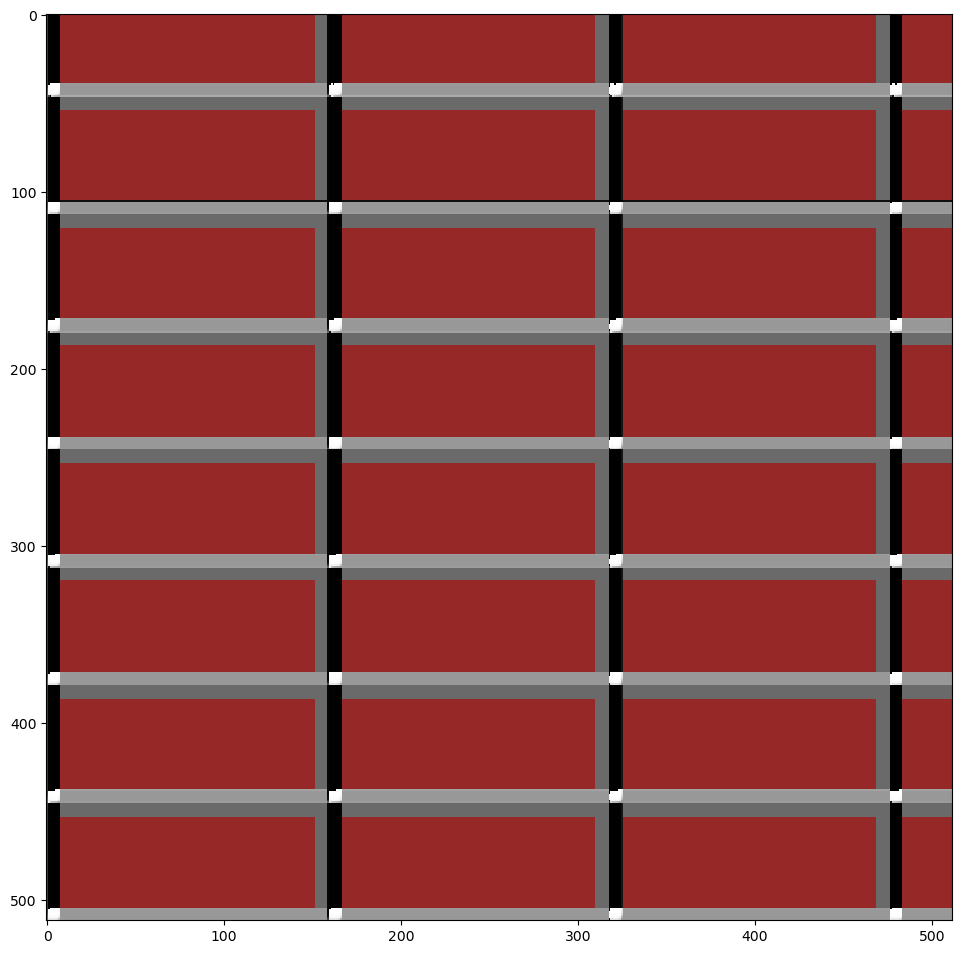

In [7]:
import numpy as np
import scipy as sp
import math

%matplotlib inline
from matplotlib import pyplot as plt

def step(a, x):
    return np.asfarray(a < x, dtype=float)

def stepf(a, x):
    return float(a < x)

a = np.random.rand(100)
b = step(0.5, a)
print(np.sum(b))

def pulse(a, b, x):
    return step(a, x) - step(b, x)

def pulsef(a, b, x):
    return stepf(a, x) - stepf(b, x)

c = pulse(0.2, 0.6, a)
print(np.sum(c))

def clamp(a, b, x):
    return np.fmin(np.fmax(a, x), b)

d = clamp(0.2, 0.7, a)
print(d)

def bias(b, x):
    return np.power(x, math.log(b) / math.log(0.5))

def gain(g, x):
    return np.where(x < 0.5, bias(1 - g, 2 * x) / 2, 1 - bias(1 - g, 2 - 2 * x) / 2)

def mix(x, y, a):
    return (1 - a) * x + a * y

def smoothstepf(a, b, x):
    if x < a:
        return 0
    if x >= b:
        return 1
    x = (x - a) / (b - a)
    return x * x * (3 - 2 * x)

def bump(a, b, u, v):
    
    ubump = smoothstepf(0, a, u) - smoothstepf(1 - a, 1, u)
    vbump = smoothstepf(0, b, v) - smoothstepf(1 - b, 1, v)
    return ubump * vbump

def brick(cbrick, cmortar, brick_w, brick_h, mortar_thickness, uoff, voff, u, v):
    light_dir = np.asarray([0, 1 / math.sqrt(2), 1 / math.sqrt(2)])
    bu = math.fmod(u - uoff, brick_w + mortar_thickness)
    bv = math.fmod(v - voff, brick_h + mortar_thickness)
    mstart = mortar_thickness * 0.5
    mendw = brick_w + mstart
    mendh = brick_h + mstart
    in_brick = pulsef(mstart, mendw, bu)
    in_brick *= pulsef(mstart, mendh, bv)
    
    up = np.asarray([0, 0, 1])
    uvec = np.asarray([1, 0, 0])
    vvec = np.asarray([0, 1, 0])
    buv = bump(mstart, mstart, bu, bv)
    bu1v = bump(mstart, mstart, bu + 0.0001, bv)
    buv1 = bump(mstart, mstart, bu, bv + 0.0001)
    buvec = np.asarray([0.0001, 0, bu1v - buv])
    buvec_len = np.linalg.norm(buvec)
    buvec /= buvec_len
    bvvec = np.asarray([0, 0.0001, buv1 - buv])
    bvvec_len = np.linalg.norm(bvvec)
    bvvec /= bvvec_len
    nn = np.cross(buvec, bvvec)
    cos_weight = np.dot(nn, light_dir)
    
    return mix(cmortar * cos_weight, cbrick, in_brick)

img_array = np.zeros((512, 512, 3), dtype=np.uint8)
for i in range(512):
    for j in range(512):
        u = j / 512.0
        v = (512 - i) / 512.0
        #img_array[i, j] = [v * 255, 0, 0]
        img_array[i, j] = brick(np.asarray([150, 40, 40]), np.asarray([150, 150, 150]), 0.28, 0.1, 0.03, 0, 0, u, v)
fig = plt.figure(figsize=(12, 12), dpi=100)
plt.imshow(img_array, interpolation='nearest')

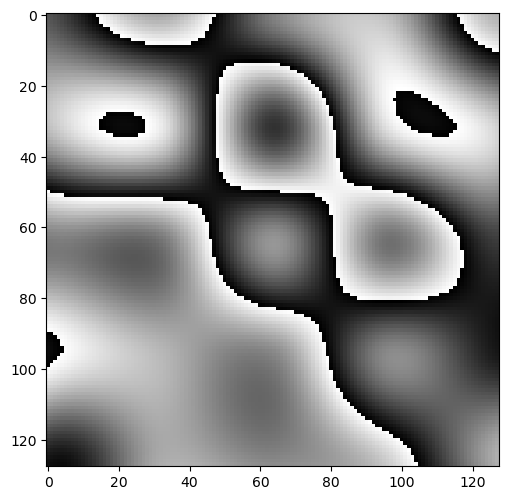

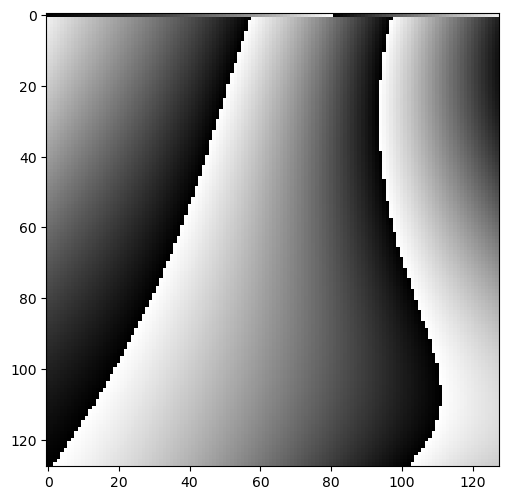

In [20]:
# Noises
import numpy as np
import scipy.interpolate
import math

%matplotlib inline
from matplotlib import pyplot as plt

# Common utilities
table_size = 256
table_mask = 255

perm_table = [
    225, 155, 210, 108, 175, 199, 221, 144, 203, 116, 70, 213, 69, 158, 33, 252,
    5, 82, 173, 133, 222, 139, 174, 27, 9, 71, 90, 246, 75, 130, 91, 191,
    169, 138, 2, 151, 194, 235, 81, 7, 25, 113, 228, 159, 205, 253, 134, 142,
    248, 65, 224, 217, 22, 121, 229, 63, 89, 103, 96, 104, 156, 17, 201, 129,
    36, 8, 165, 110, 237, 117, 231, 56, 132, 211, 152, 20, 181, 111, 239, 218,
    170, 163, 51, 172, 157, 47, 80, 212, 176, 250, 87, 49, 99, 242, 136, 189,
    162, 115, 44, 43, 124, 94, 150, 16, 141, 247, 32, 10, 198, 223, 255, 72,
    53, 131, 84, 57, 220, 197, 58, 50, 208, 11, 241, 28, 3, 192, 62, 202,
    18, 215, 153, 24, 76, 41, 15, 179, 39, 46, 55, 6, 128, 167, 23, 188,
    106, 34, 187, 140, 164, 73, 112, 182, 244, 195, 227, 13, 35, 77, 196, 185,
    26, 200, 226, 119, 31, 123, 168, 125, 249, 68, 183, 230, 177, 135, 160, 180,
    12, 1, 243, 148, 102, 166, 38, 238, 251, 37, 240, 126, 64, 74, 161, 40,
    184, 149, 171, 178, 101, 66, 29, 59, 146, 61, 254, 107, 42, 86, 154, 4,
    236, 232, 120, 21, 233, 209, 45, 98, 193, 114, 78, 19, 206, 14, 118, 127,
    48, 79, 147, 85, 30, 207, 219, 54, 88, 234, 190, 122, 95, 67, 143, 109,
    137, 214, 145, 93, 92, 100, 245, 0, 216, 186, 60, 83, 105, 97, 204, 52
]

def perm(x):
    """
    A simple mask function to clamp index within 0 - 256
    """
    return perm_table[x & table_mask]

def index(x, y, z):
    """
    Permutation with 3 dimension indices
    """
    return perm(perm(perm(int(x)) + int(y)) + int(z))

# spline interpolation
cr00 = -0.5
cr01 = 1.5
cr02 = -1.5
cr03 = 0.5
cr10 = 1.0
cr11 = -2.5
cr12 = 2.0
cr13 = -0.5
cr20 = -0.5
cr21 = 0.0
cr22 = 0.5
cr23 = 0.0
cr30 = 0.0
cr31 = 1.0
cr32 = 0.0
cr33 = 0.0

def clamp(a, b, x):
    return min(max(a, x), b)

def spline(x, knots):
    nspans = len(knots) - 3
    if nspans < 1:
        raise Exception('not enough spans')
    x = clamp(0, 1, x) * nspans
    span = int(x)
    if span >= len(knots) - 3:
        span = len(knots) - 3
    x -= span
    idx = span
    c3 = cr00 * knots[idx] + cr01 * knots[idx + 1] + cr02 * knots[idx + 2] + cr03 * knots[idx + 3]
    c2 = cr10 * knots[idx] + cr11 * knots[idx + 1] + cr12 * knots[idx + 2] + cr13 * knots[idx + 3]
    c1 = cr20 * knots[idx] + cr21 * knots[idx + 1] + cr22 * knots[idx + 2] + cr23 * knots[idx + 3]
    c0 = cr30 * knots[idx] + cr31 * knots[idx + 1] + cr32 * knots[idx + 2] + cr33 * knots[idx + 3]
    return ((c3 * x + c2) * x + c1) * x + c0

# Value noise: generate random number at each lattice point and interpolate between each other
# random value table with values ranged in -1 ~ 1
rand_table = 1 - 2 * np.random.rand(table_size)

def vlattice(x, y, z):
    """
    Calculate value noise lattice point value
    """
    return rand_table[index(x, y, z)]

def vnoise(x, y, z):
    """
    Actual value noise calculation function
    Interpolate with Catmull-Rom spline interpolation
    """
    ix = math.floor(x)
    fx = x - ix
    iy = math.floor(y)
    fy = y - iy
    iz = math.floor(z)
    fz = z - iz
    
    xknots = [0] * 4
    yknots = [0] * 4
    zknots = [0] * 4
    basis = [0, 1, 2, 3]
    
    for k in range(-1, 3):
        for j in range(-1, 3):
            for i in range(-1, 3):
                xknots[i + 1] = vlattice(ix + i, iy + j, iz + k)
            yknots[j + 1] = spline(fx, xknots)
        zknots[k + 1] = spline(fy, yknots)
    return spline(fz, zknots)

img_array1 = np.zeros((128, 128, 3), dtype=np.uint8)
for i in range(128):
    for j in range(128):
        u = j / 128.0
        v = (128 - i) / 128.0
        img_array1[i, j] = vnoise(u / 0.25, v / 0.25, 0) * 255
        
fig1 = plt.figure(figsize=(6, 6), dpi=100)
plt.imshow(img_array1, interpolation='nearest')

# gradient related stuffs
gradients = np.ndarray(shape=(table_size, 3))
for i in range(table_size):
    rands = np.random.rand(2)
    z = 1 - 2 * rands[0]
    r = math.sqrt(1 - z * z)
    theta = 2 * math.pi * rands[1]
    gradients[i] = [r * math.cos(theta), r * math.sin(theta), z]

def glattice(x, y, z, fx, fy, fz):
    """
    Calculate gradient noise lattice point value
    """
    idx = index(x, y, z)
    return gradients[idx, 0] * fx + gradients[idx, 1] * fy + gradients[idx, 2] * fz

def lerp(t, a, b):
    return a + t * (a - b)

def smoothstep(x):
    return x * x * (3 - 2 * x)

def gnoise(x, y, z):
    ix = math.floor(x)
    iy = math.floor(y)
    iz = math.floor(z)
    fx0 = x - ix
    fx1 = fx0 - 1
    fy0 = y - iy
    fy1 = fy0 - 1
    fz0 = z - iz
    fz1 = fz0 - 1
    wx = smoothstep(fx0)
    wy = smoothstep(fy0)
    wz = smoothstep(fz0)
    
    vx0 = glattice(ix, iy, iz, fx0, fy0, fz0)
    vx1 = glattice(ix + 1, iy, iz, fx1, fy0, fz0)
    vy0 = lerp(wx, vx0, vx1)
    vx0 = glattice(ix, iy + 1, iz, fx0, fy1, fz0)
    vx1 = glattice(ix + 1, iy + 1, iz, fx1, fy1, fz0)
    vy1 = lerp(wx, vx0, vx1)
    vz0 = lerp(wy, vy0, vy1)
    vx0 = glattice(ix, iy, iz + 1, fx0, fy0, fz0)
    vx1 = glattice(ix + 1, iy, iz + 1, fx1, fy0, fz1)
    vy0 = lerp(wx, vx0, vx1)
    vx0 = glattice(ix, iy + 1, iz + 1, fx0, fy1, fz1)
    vx1 = glattice(ix + 1, iy + 1, iz + 1, fx1, fy1, fz1)
    vy1 = lerp(wx, vx0, vx1)
    vz1 = lerp(wy, vy0, vy1)
    return lerp(wz, vz0, vz1)

img_array2 = np.zeros((128, 128, 3), dtype=np.uint8)
for i in range(128):
    for j in range(128):
        u = j / 128.0
        v = (128 - i) / 128.0
        img_array2[i, j] = gnoise(u, v, 0) * 255
        
fig2 = plt.figure(figsize=(6, 6), dpi=100)
plt.imshow(img_array2, interpolation='nearest')
    